# A simple GNN model

In [ ]:
!pip install rdkit

In [ ]:
!pip install torch_geometric

In [ ]:
# Utilities
from tqdm.notebook import tqdm
# Scientific python
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.axisbelow'] = True
plt.rcParams['figure.figsize'] = [7, 5]
plt.rcParams["text.usetex"] = False
import sklearn
from sklearn.metrics import r2_score , mean_absolute_error , mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

# Pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric
import torch_geometric.nn as gnn
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch.utils.data import Subset
from torch_geometric.nn.pool import global_add_pool
from torch.utils.data import TensorDataset

# RDKit
import rdkit
from rdkit import Chem
print('Pytorch version:',torch.__version__)
print('Pytorch Geometric version:',torch_geometric.__version__)
print('RDKit version:', rdkit.__version__)
tqdm.pandas()

Pytorch version: 2.1.0+cu121
Pytorch Geometric version: 2.5.0
RDKit version: 2023.09.5


## Load data and normalize

In [ ]:
df = pd.read_csv('data_cleaned.csv')

In [ ]:
train_df = df[df['Split'] == 'Training'].copy()
test_df = df[df['Split'] == 'Testing'].copy()

# Extract features and target
features = ['T (K)', 'P (kPa)', 'r HBA', 'r HBD']
X_train = train_df[features].values
y_train = train_df['ln(x)-experimental'].values
X_test = test_df[features].values
y_test = test_df['ln(x)-experimental'].values

# Normalize the features
scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)

# Add normalized features back to the original DataFrame
norm_feature_names = ['T_norm', 'P_norm', 'r_HBA_norm', 'r_HBD_norm']
train_df[norm_feature_names] = X_train_norm
test_df[norm_feature_names] = X_test_norm

# Combine the training and testing dataframes
df = pd.concat([train_df, test_df])

# to preserve the original order
df = df.sort_index()

## Add SMILES

In [ ]:
df_hba = pd.read_csv('HBA_smiles.csv')
df_hbd = pd.read_csv('HBD_smiles.csv')

In [ ]:
df['HBA_SMILES'] = df['HBA name'].map(df_hba.set_index('Short')['SMILES'])
df['HBD_SMILES'] = df['HBD name'].map(df_hbd.set_index('Short')['SMILES'])

## Create molecules

In [ ]:
df['mol_hba'] = df['HBA_SMILES'].apply(Chem.MolFromSmiles)
df['mol_hbd'] = df['HBD_SMILES'].apply(Chem.MolFromSmiles)

## Get statistics of molecules

In [ ]:
def get_statistics_molecular_data(df, report):

    # Open report file
    report = open(report, 'w')
    def print_report(string, file=report):
        print(string)
        file.write('\n' + string)

    print_report('Statistics of molecular data')
    print_report('-'*50)

    # SMILES to mol
    mol_col     = 'molecule'
    df[mol_col] = df['SMILES'].apply(Chem.MolFromSmiles)

    ###########################
    # --- Count molecules --- #
    ###########################
    n_mols = df.shape[0]
    print_report('Number of molecules: ' +str(n_mols))

    ######################################
    # --- Atoms features in database --- #
    ######################################


    print_report('-'*40)
    molecules = df[mol_col].tolist()

    Symbols           = {}
    Hybridazation     = {}
    Num_bonds         = {}
    Formal_Charge     = {}
    Total_Hs          = {}
    Chirality         = {}

    for mol in molecules:
        atoms = mol.GetAtoms()
        for atom in atoms:
            # Type
            s = atom.GetSymbol()
            if s not in Symbols: Symbols[s] = 1
            else: Symbols[s] += 1

            # Hibridazation
            h = atom.GetHybridization()
            if h not in Hybridazation: Hybridazation[h] = 1
            else: Hybridazation[h] += 1

            # Number of bonds
            nb = len(atom.GetNeighbors())
            if nb not in Num_bonds: Num_bonds[nb] = 1
            else: Num_bonds[nb] += 1

            # Formal charge
            fc = atom.GetFormalCharge()
            if fc not in Formal_Charge: Formal_Charge[fc] = 1
            else: Formal_Charge[fc] += 1

            # Number of Hydrogens
            Hs = atom.GetTotalNumHs()
            if Hs not in Total_Hs: Total_Hs[Hs] = 1
            else: Total_Hs[Hs] += 1

            # Chirality
            ct = atom.GetChiralTag()
            if ct not in Chirality: Chirality[ct] = 1
            else: Chirality[ct] += 1

    # Change labels chirality
    legend = {0:'UNSPECIFIED', 1:'CLOCKWISE', 2:'COUNTER-CLOCKWISE',
                        3:'UNRECOGNIZED '}
    for i in list(Chirality):
        if i in legend:
            Chirality[legend[i]] = Chirality.pop(i)

    print_report('\nATOMS: ')
    print_report('-'*20)

    print_report('   Type of atoms')
    print_report(pd.DataFrame(Symbols, index=['']).to_string())

    print_report('   \nHibridazation')
    print_report(str(Hybridazation))
    print_report(pd.DataFrame(Hybridazation, index=['']).to_string())

    print_report('   \nNumber of bonds')
    print_report(pd.DataFrame(Num_bonds, index=['']).to_string())

    print_report('   \nFormal charge')
    print_report(pd.DataFrame(Formal_Charge, index=['']).to_string())

    print_report('   \nNumber of Hydrogens')
    print_report(pd.DataFrame(Total_Hs, index=['']).to_string())

    print_report('   \nChirality')
    print_report(pd.DataFrame(Chirality, index=['']).to_string())


    #####################################
    # --- Type of bonds in database --- #
    #####################################
    bond_types   = {}
    Stereo       = {}

    for mol in molecules:
        bonds = mol.GetBonds()
        for bond in bonds:
            # Type of bond
            s = bond.GetBondType()
            if s not in bond_types: bond_types[s] = 1
            else: bond_types[s] += 1

            # Stereo
            st = bond.GetStereo()
            if st not in Stereo: Stereo[st] = 1
            else: Stereo[st] += 1



    print_report('\nBONDS: ')
    print_report('-'*20)
    legend = {0:'UNSPECIFIED', 1:'SINGLE', 2:'DOUBLE', 3:'TRIPLE ',
                12:'AROMATIC', 13:'IONIC', 14:'HYDROGEN'}
    print_report('   Type of atoms')
    for i in bond_types:
        if i in legend:
            bond_types[legend[i]] = bond_types.pop(i)
    print_report(pd.DataFrame(bond_types, index=['']).to_string())
    print_report('   \nStereo:')
    legend = {0:'NONE', 1:'ANY', 2:'Z', 3:'E ',
                4:'CIS', 5:'TRANS'}
    for i in list(Stereo):
        if i in legend:
            Stereo[legend[i]] = Stereo.pop(i)
    print_report(pd.DataFrame(Stereo, index=['']).to_string())

    report.close()

In [ ]:
df_mols = pd.concat([df_hba, df_hbd], axis=0)
get_statistics_molecular_data(df_mols, 'statistics_mols.txt')

Statistics of molecular data
--------------------------------------------------
Number of molecules: 50
----------------------------------------

ATOMS: 
--------------------
   Type of atoms
    C   O   N  Cl  Br  P
  437  56  32  14   7  3
   
Hibridazation
{rdkit.Chem.rdchem.HybridizationType.SP3: 407, rdkit.Chem.rdchem.HybridizationType.SP2: 140, rdkit.Chem.rdchem.HybridizationType.SP: 2}
    4    3  2
  407  140  2
   
Number of bonds
    1   3    2   4   0
  150  46  312  20  21
   
Formal charge
    0   1  -1
  505  22  22
   
Number of Hydrogens
   3   0    2    1
  93  97  232  127
   
Chirality
  UNSPECIFIED
          549

BONDS: 
--------------------
   Type of atoms
  AROMATIC  TRIPLE  SINGLE  DOUBLE
        99       1     384      12
   
Stereo:
  NONE
   496


## Create graphs

In [ ]:
def one_of_k_encoding(x, allowable_set):
    if x not in allowable_set:
        raise Exception("input {0} not in allowable set{1}:".format(
            x, allowable_set))
    return list(map(lambda s: x == s, allowable_set))

### Atomic features

In [ ]:
possible_atom_list = [
    'C',
    'O',
    'N',
    'Cl',
    'Br',
    'P',
    ]
possible_hybridization = [
    Chem.rdchem.HybridizationType.SP,
    Chem.rdchem.HybridizationType.SP2,
    Chem.rdchem.HybridizationType.SP3
    ]
possible_num_bonds = [
    0,
    1,
    2,
    3,
    4
    ]
possible_formal_charge = [
    0,
    1,
    -1
    ]
possible_num_Hs  = [
    0,
    1,
    2,
    3
    ]

def atom_features(atom):
    '''
    Get atom features
    '''
    Symbol       = atom.GetSymbol()
    Type_atom     = one_of_k_encoding(Symbol, possible_atom_list)
    Ring_atom     = [atom.IsInRing()]
    Aromaticity   = [atom.GetIsAromatic()]
    Hybridization = one_of_k_encoding(atom.GetHybridization(), possible_hybridization)
    Bonds_atom    = one_of_k_encoding(len(atom.GetNeighbors()), possible_num_bonds)
    Formal_charge = one_of_k_encoding(atom.GetFormalCharge(), possible_formal_charge)
    num_Hs        = one_of_k_encoding(atom.GetTotalNumHs(), possible_num_Hs)

    results = Type_atom + Ring_atom + Aromaticity + Hybridization + Bonds_atom +  \
      Formal_charge + num_Hs
    return np.array(results).astype(np.float32)

### Bond features

In [ ]:
def get_bond_pair(mol):
    bonds = mol.GetBonds()
    res = [[], []]
    for bond in bonds:
        res[0] += [bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()]
        res[1] += [bond.GetEndAtomIdx(), bond.GetBeginAtomIdx()]
    return res

def bond_features(bond):
    bt = bond.GetBondType()
    # Features
    bond_feats = [
        bt == Chem.rdchem.BondType.SINGLE, bt == Chem.rdchem.BondType.DOUBLE,
        bt == Chem.rdchem.BondType.TRIPLE, bt == Chem.rdchem.BondType.AROMATIC,
        bond.GetIsConjugated(),
        bond.IsInRing()]
    return np.array(bond_feats).astype(np.float32)

### Utilities

In [ ]:
def n_atom_features():
    atom = Chem.MolFromSmiles('CC').GetAtomWithIdx(0)
    return len(atom_features(atom))

def n_bond_features():
    bond = Chem.MolFromSmiles('CC').GetBondWithIdx(0)
    return len(bond_features(bond))

def sys2graph(df, mol_column_1, mol_column_2, target, single_system=False):
    """
    Constructs graph representations of binary molecular systems.

    Parameters:
    df (pd.DataFrame): Input dataframe.
    mol_column_1 (str): Column name for the first component.
    mol_column_2 (str): Column name for the second component.
    target (str): Column name for the target variable.
    single_system (bool, optional): Whether to treat the dataframe as a single system.

    Returns:
    list: A list of graph objects.
    """
    def process_component(comp):
        """Processes a single component to extract edge attributes and indices."""
        edge_attr = []
        edge_index = get_bond_pair(comp)
        for bond in comp.GetBonds():
            edge_attr.extend([bond_features(bond)] * 2)
        return edge_attr, edge_index

    def combine_graph_info(node_feat_c1, edge_indx_c1, edge_attr_c1, node_feat_c2, edge_indx_c2, edge_attr_c2):
        """Combines node and edge information from both components."""
        num_features_c1 = len(node_feat_c1)
        nodes_info = torch.tensor(np.array(node_feat_c1 + node_feat_c2), dtype=torch.float32)
        edges_indx = torch.cat((torch.tensor(np.array(edge_indx_c1), dtype=torch.long),
                                torch.tensor(np.array(edge_indx_c2), dtype=torch.long) + num_features_c1), 1)
        edges_info = torch.tensor(np.array(edge_attr_c1 + edge_attr_c2), dtype=torch.float32)
        return nodes_info, edges_indx, edges_info

    def create_graph_object(nodes, edges_indx, edges_info, y):
        """Creates a graph object with target value."""
        graph = Data(x=nodes, edge_index=edges_indx, edge_attr=edges_info)
        graph.y = torch.tensor(y, dtype=torch.float)
        return graph

    def create_graph(c1, c2, y_val):
        """Helper function to create a graph from two components."""
        atoms_c1 = c1.GetAtoms()
        atoms_c2 = c2.GetAtoms()
        node_features_c1 = [atom_features(atom) for atom in atoms_c1]
        node_features_c2 = [atom_features(atom) for atom in atoms_c2]

        edge_attr_c1, edge_index_c1 = process_component(c1)
        edge_attr_c2, edge_index_c2 = process_component(c2)

        # Combine node and edge information
        nodes_info, edges_indx, edges_info = combine_graph_info(node_features_c1, edge_index_c1, edge_attr_c1,
                                                               node_features_c2, edge_index_c2, edge_attr_c2)

        # Create graph object
        graph = create_graph_object(nodes_info, edges_indx, edges_info, y_val)
        return graph

    # Main function logic
    graphs = []
    c1 = [df[mol_column_1]] if single_system else df[mol_column_1].tolist()
    c2 = [df[mol_column_2]] if single_system else df[mol_column_2].tolist()
    ys = [df[target]] if single_system else df[target].tolist()
    Ts = [df['T_norm']] if single_system else df['T_norm'].tolist()
    Ps = [df['P_norm']] if single_system else df['P_norm'].tolist()
    hba_xs = [df['r_HBA_norm']] if single_system else df['r_HBA_norm'].tolist()
    hbd_xs = [df['r_HBD_norm']] if single_system else df['r_HBD_norm'].tolist()

    for y, comp1, comp2, T, P, hba_x, hbd_x in tqdm(zip(ys, c1, c2, Ts, Ps, hba_xs, hbd_xs), total=len(ys)):
        graph = create_graph(comp1, comp2, y)
        # Append extra info to the graph
        graph.Temp = T
        graph.P = P
        graph.hba_x = hba_x
        graph.hbd_x = hbd_x

        graphs.append(graph)
    return graphs

In [ ]:
n_atom_features()

23

In [ ]:
n_bond_features()

6

In [ ]:
y_val = df['ln(x)-experimental'].iloc[0]
y_val

-5.7138

In [ ]:
df['g_des'] = sys2graph(df, 'mol_hba', 'mol_hbd', 'ln(x)-experimental')

  0%|          | 0/1973 [00:00<?, ?it/s]

Let's look at one example of the DES graph and compare it to the actual molecules

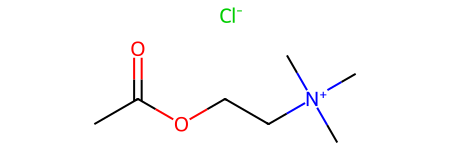

In [ ]:
c1 = df['mol_hba'].iloc[0]
c1

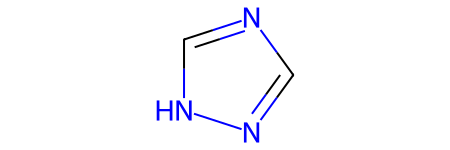

In [ ]:
c2 = df['mol_hbd'].iloc[0]
c2

In [ ]:
graph_des = df['g_des'].iloc[0]
graph_des

Data(x=[16, 23], edge_index=[2, 28], edge_attr=[28, 6], y=-5.713799953460693, Temp=-0.7361586343092329, P=-0.7537792896526903, hba_x=-0.1298835178532465, hbd_x=-1.3523710716801727)

We can note that the DES graph has 16 nodes (corresponding to the 16 atoms of the DES (11 for the HBA and 5 for the HBD)) and 28 edges (corresponding to the 28 covalent bonds of the DES (9 from HBA and 5 from HBD, and as they are bidirected, we obtain 28)). The target value corresponds exactly as well as the T, P and molar ratios.

In [ ]:
graph_des.edge_index

tensor([[ 0,  1,  1,  2,  1,  3,  3,  4,  4,  5,  5,  6,  6,  7,  6,  8,  6,  9,
         11, 12, 12, 13, 13, 14, 14, 15, 15, 11],
        [ 1,  0,  2,  1,  3,  1,  4,  3,  5,  4,  6,  5,  7,  6,  8,  6,  9,  6,
         12, 11, 13, 12, 14, 13, 15, 14, 11, 15]])

## Graph Neural Network

In [ ]:
class GCNet(torch.nn.Module):
    def __init__(self, v_in, e_in, conv_dim, net_dim, n_extra_inputs):
        super(GCNet, self).__init__()
        self.conv1 = gnn.GCNConv(v_in, conv_dim)
        self.conv2 = gnn.GCNConv(conv_dim, conv_dim)
        # NNet part
        self.mlp1 = nn.Linear(conv_dim + n_extra_inputs, net_dim + n_extra_inputs)
        self.mlp2 = nn.Linear(net_dim + n_extra_inputs, net_dim)
        self.mlp3 = nn.Linear(net_dim, 1)
    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = F.sigmoid(self.conv1(x, edge_index))
        x = F.sigmoid(self.conv2(x, edge_index))

        # Graph embedding
        x = global_add_pool(x, data.batch)

        # NNet part
        T = torch.reshape(data.Temp,(-1,1))
        P = torch.reshape(data.P,(-1,1))
        hba_x = torch.reshape(data.hba_x,(-1,1))
        hbd_x = torch.reshape(data.hbd_x,(-1,1))
        x = torch.cat((x,T,P,hba_x,hbd_x),1)

        x = F.sigmoid(self.mlp1(x))
        x = F.sigmoid(self.mlp2(x))
        # Prediction
        x = self.mlp3(x)
        return x

class AccumulationMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.value = 0.0
        self.sum = 0.0
        self.count = 0.0
        self.avg = 0.0

    def update(self, value, n=1):
        self.value = value
        self.sum += value * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
train_df = df[df['Split'] == 'Training']
test_df = df[df['Split'] == 'Testing']

train_dataloader = DataLoader(train_df['g_des'].tolist(), batch_size=32, shuffle=False, drop_last=False)
test_dataloader = DataLoader(test_df['g_des'].tolist(), batch_size=32, shuffle=False, drop_last=False)

In [ ]:
def train(model, device, dataloader, optimizer, loss_fn):
    """
    Trains the model.

    Parameters:
    model: The neural network model to train.
    device: The device (CPU or CUDA) to use for training.
    dataloader: DataLoader object for the training data.
    optimizer: Optimizer for the training process.
    loss_fn: Loss function used for training.

    Returns:
    Average loss over the training dataset.
    """
    model.train()
    loss_accum = AccumulationMeter()
    for batch in dataloader:
        X, y =  batch, batch.y
        X, y = X.to(device), y.to(device)

        # Model prediction and loss calculation
        y_hat = model(X)
        loss = loss_fn(y_hat, y.reshape(-1,1))
        loss_accum.update(loss.item(), y.size(0))

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return loss_accum.avg

def test(model, device, dataloader, loss_fn):
    """
    Evaluates the model's performance on a test dataset.

    Parameters:
    model: The neural network model to evaluate.
    device: The device (CPU or CUDA) to use for evaluation.
    dataloader: DataLoader object for the test data.
    loss_fn: Loss function used for evaluation.

    Returns:
    Average loss over the test dataset.
    """
    model.eval()  # Set the model to evaluation mode
    loss_accum = AccumulationMeter()
    with torch.no_grad():  # Disable gradient computation
        for batch in dataloader:
            X, y =  batch, batch.y
            X, y = X.to(device), y.to(device)  # Move data to the specified device

            # Model prediction and loss calculation
            y_hat = model(X)
            loss = loss_fn(y_hat, y.reshape(-1,1))
            loss_accum.update(loss.item(), y.size(0))

    return loss_accum.avg

To construct a baseline, let's just use the same hidden dimension as for the ANN (9) and same number of epochs (1000).

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = GCNet(n_atom_features(), n_bond_features(), 9, 9, 4).to(device)

loss_fn = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
epochs = 1000

In [ ]:
train_loss_save, test_loss_save = [], []
for epoch in tqdm(range(epochs)):
    train_loss = train(model, device, train_dataloader, optimizer, loss_fn)
    train_loss_save.append(train_loss)
    test_loss = test(model,device,test_dataloader,loss_fn)
    test_loss_save.append(test_loss)

torch.save({
    'epoch': epoch + 1,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    },
           'GNN_baseline.pth')

  0%|          | 0/1000 [00:00<?, ?it/s]

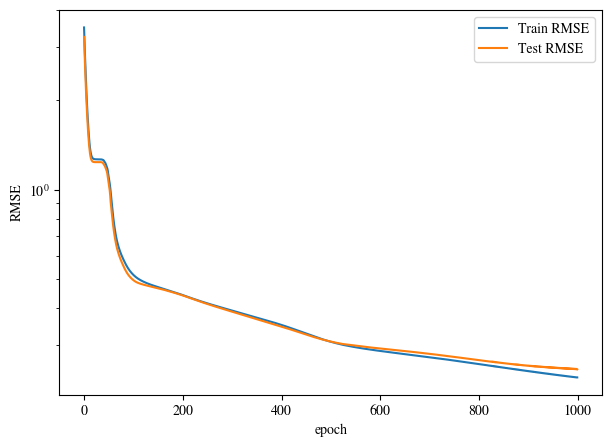

In [ ]:
train_mse = np.sqrt(np.array(train_loss_save))
test_mse = np.sqrt(np.array(test_loss_save))
plt.plot(train_mse,label="Train RMSE")
plt.plot(test_mse,label="Test RMSE")
plt.xlabel("epoch")
plt.ylabel("RMSE")
plt.legend(loc="best")
plt.yscale('log')

In [ ]:
model = GCNet(n_atom_features(), n_bond_features(), 9, 9, 4).to(device)
checkpoint = torch.load('GNN_baseline.pth')
model.load_state_dict(checkpoint['model_state_dict'])

y_hat_training, y_hat_testing = [] ,[]
model.eval()
with torch.no_grad():
  for y_storage, dataloader in zip([y_hat_training, y_hat_testing], [train_dataloader, test_dataloader]):
    for batch in dataloader:
      X, y = batch, batch.y
      X, y = X.to(device), y.to(device)
      y_hat = model(X).cpu().numpy().tolist()
      y_storage.extend(y_hat)

In [ ]:
def parity_plots(y_train, y_train_hat, y_test, y_test_hat):

  metrics = [r2_score, mean_absolute_percentage_error, mean_absolute_error, mean_squared_error]
  metric_names = ['R2', 'MAPE', 'MAE', 'RMSE']

  metrics_dict = {}
  for split, (y_true, y_pred) in zip(['train', 'test'], [(y_train, y_train_hat), (y_test, y_test_hat)]):
    metrics_dict[split] = {}
    for name, metric in zip(metric_names, metrics):
      metrics_dict[split][name] = metric(y_true, y_pred)

  metrics_train = (r'$R^2 = {:.2f} $' '\n' r'$AARD = {:.2f}$ %' '\n' r'$MAE = {:.2f}$' '\n' r'$RMSE = {:.2f}$' .format(
      metrics_dict['train']['R2'],
      metrics_dict['train']['MAPE']*100,
      metrics_dict['train']['MAE'],
      metrics_dict['train']['RMSE']**0.5))

  metrics_test = (r'$R^2 = {:.2f} $' '\n' r'$AARD = {:.2f}$ %' '\n' r'$MAE = {:.2f}$' '\n' r'$RMSE = {:.2f}$' .format(
      metrics_dict['test']['R2'],
      metrics_dict['test']['MAPE']*100,
      metrics_dict['test']['MAE'],
      metrics_dict['test']['RMSE']**0.5))

  fig , (ax1,ax2) = plt.subplots(1,2, figsize=(10.0 ,5.0))

  ax1.set_xlabel(r'$ln(x^{exp}_{CO_2}) $')
  ax1.set_ylabel(r'$ln(x^{pred}_{CO_2}) $')
  ax1.set_ylim([-7.5,-0.5])
  ax1.set_xlim([-7.5,-0.5])
  ax1.text(-6.8,-2.5, metrics_train, fontsize=10)
  ax1.grid(visible=True,which='major',linestyle = '--' ,linewidth = 0.5)
  ax1.scatter(y_train, y_train_hat, label='Training', marker='s', color='red')
  ax1.plot(np.linspace(-7,-1), np.linspace(-7,-1),linestyle = '--' , color  = 'black')
  ax1.legend(loc="best")

  ax2.set_xlabel(r'$ln(x^{exp}_{CO_2}) $')
  ax2.set_ylabel(r'$ln(x^{pred}_{CO_2}) $')
  ax2.set_ylim([-7.5,-0.5])
  ax2.set_xlim([-7.5,-0.5])
  ax2.text(-6.8,-2.5, metrics_test, fontsize=10)
  ax2.grid(visible=True,which='major', linestyle = '--' ,linewidth = 0.5)
  ax2.scatter(y_test, y_test_hat, label='Testing', marker='s', color='blue')
  ax2.plot(np.linspace(-7,-1),np.linspace(-7,-1),linestyle = '--' , color  = 'black')
  ax2.legend(loc="best")

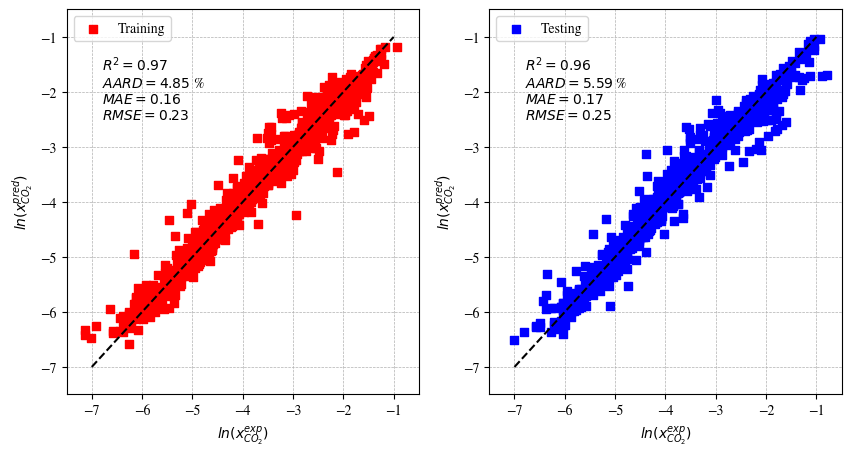

In [ ]:
parity_plots( y_train, y_hat_training, y_test, y_hat_testing)

Well, the results are not so bad, but they are actually worse than our random forest baseline model that was trained on MACCS fingerprints. Let's see if by optimizing the hyperparameters, the prediction accurcay increases.

## Hyperparameter optimization

In [ ]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 7.6 MB/s eta 0:00:00


In [ ]:
import optuna

In [ ]:
def objective(trial):
    # Hyperparameters to be optimized
    conv_dim = trial.suggest_int('graph convolution dimensions', 4, 32)
    net_dim = trial.suggest_int('final MLP dimensions', 4, 32)
    lr = trial.suggest_float('lr', 1e-4, 1e-1, log=True)

    # Model and optimizer
    model = GCNet(n_atom_features(), n_bond_features(), conv_dim, net_dim, 4).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # K-fold cross-validation
    k = 5
    mapes = []
    train_data = train_df['g_des'].tolist()
    kf = KFold(n_splits=k, shuffle=True, random_state=42)

    for fold, (train_idx, val_idx) in enumerate(kf.split(train_data)):
      train_subset = Subset(train_data, train_idx)
      val_subset = Subset(train_data, val_idx)

      train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
      val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)

      #print(f"Fold {fold + 1}")

      # training loop
      for epoch in tqdm(range(epochs)):
          train_loss = train(model, device, train_loader, optimizer, loss_fn)
      # evaluation
      y_valid, y_hat_valid = [] ,[]
      model.eval()
      with torch.no_grad():
        for batch in val_loader:
          X, y = batch, batch.y
          X, y = X.to(device), y.to(device)
          y_hat = model(X).cpu().numpy().tolist()

          y_valid.extend(y.cpu().numpy().tolist())
          y_hat_valid.extend(y_hat)
      val_mape = mean_absolute_percentage_error(y_valid, y_hat_valid)*100
      #print('---> Val MAPE: ', np.round(val_mape,3))
      mapes.append(val_mape)

    return np.mean(mapes)

In [ ]:
study_name = 'GNN_simple'
storage_traj = f'sqlite:///{study_name}.db'
study = optuna.create_study(direction='minimize', study_name=study_name, storage=storage_traj, load_if_exists=True)

max_trials = 60
completed_trials = len(study.trials)
trials_left = max_trials - completed_trials

if trials_left > 0:
    study.optimize(objective, n_trials=trials_left)
else:
    print("Maximum number of trials already reached or exceeded.")

[I 2024-03-01 09:22:49,242] Using an existing study with name 'GNN_simple' instead of creating a new one.


Maximum number of trials already reached or exceeded.


In [ ]:
# Best hyperparameters
print(study.best_params)

{'graph convolution dimensions': 31, 'final MLP dimensions': 22, 'lr': 0.0050834868253026395}


In [ ]:
from optuna.visualization import plot_optimization_history, plot_param_importances, plot_slice

In [ ]:
plot_optimization_history(study)

In [ ]:
plot_param_importances(study)

In [ ]:
plot_slice(study)

In [ ]:
lr = 0.0050834868253026395
model = GCNet(n_atom_features(), n_bond_features(), 31, 22, 4).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = lr)

train_loss_save, test_loss_save = [], []
for epoch in tqdm(range(epochs)):
    train_loss = train(model, device, train_dataloader, optimizer, loss_fn)
    train_loss_save.append(train_loss)
    test_loss = test(model,device,test_dataloader,loss_fn)
    test_loss_save.append(test_loss)

torch.save({
    'epoch': epoch + 1,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    },
           'GNN_simple.pth')

  0%|          | 0/1000 [00:00<?, ?it/s]

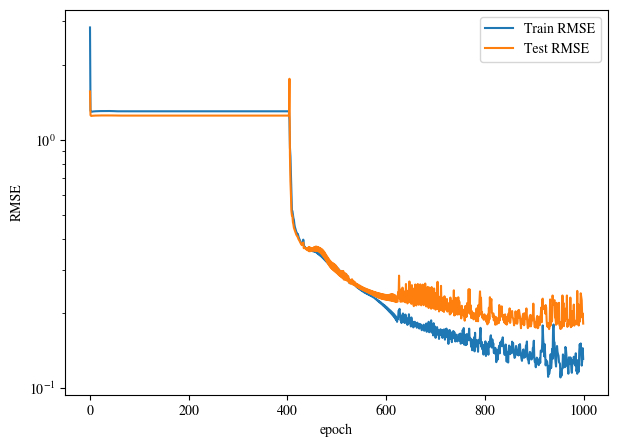

In [ ]:
train_mse = np.sqrt(np.array(train_loss_save))
test_mse = np.sqrt(np.array(test_loss_save))
plt.plot(train_mse,label="Train RMSE")
plt.plot(test_mse,label="Test RMSE")
plt.xlabel("epoch")
plt.ylabel("RMSE")
plt.legend(loc="best")
plt.yscale('log')

In [ ]:
model = GCNet(n_atom_features(), n_bond_features(), 31,22, 4).to(device)
checkpoint = torch.load('GNN_simple.pth')
model.load_state_dict(checkpoint['model_state_dict'])

y_hat_training, y_hat_testing = [] ,[]
model.eval()
with torch.no_grad():
  for y_storage, dataloader in zip([y_hat_training, y_hat_testing], [train_dataloader, test_dataloader]):
    for batch in dataloader:
      X, y = batch, batch.y
      X, y = X.to(device), y.to(device)
      y_hat = model(X).cpu().numpy().tolist()
      y_storage.extend(y_hat)

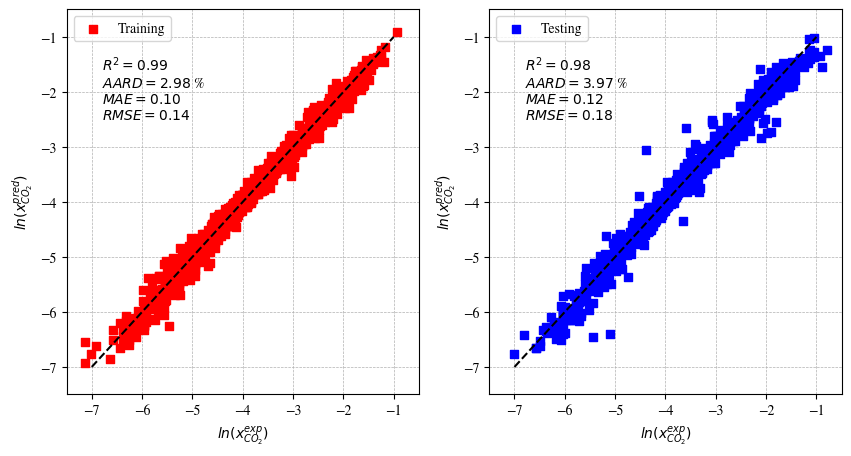

In [ ]:
parity_plots( y_train, y_hat_training, y_test, y_hat_testing)

### 10-runs

In [ ]:
y_train_hat_lst = []
y_test_hat_lst = []

for i in range(10):
  # Training
  model = GCNet(n_atom_features(), n_bond_features(), 31, 22, 4).to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr = lr)

  train_loss_save, test_loss_save = [], []
  for epoch in tqdm(range(epochs)):
      train_loss = train(model, device, train_dataloader, optimizer, loss_fn)
      train_loss_save.append(train_loss)
      test_loss = test(model,device,test_dataloader,loss_fn)
      test_loss_save.append(test_loss)

  torch.save({
      'epoch': epoch + 1,
      'model_state_dict': model.state_dict(),
      'optimizer_state_dict': optimizer.state_dict(),
      },
            'current_GNN_simple.pth')
  # Prediction
  model = GCNet(n_atom_features(), n_bond_features(), 31,22, 4).to(device)
  checkpoint = torch.load('current_GNN_simple.pth')
  model.load_state_dict(checkpoint['model_state_dict'])

  y_hat_training, y_hat_testing = [] ,[]
  model.eval()
  with torch.no_grad():
    for y_storage, dataloader in zip([y_hat_training, y_hat_testing], [train_dataloader, test_dataloader]):
      for batch in dataloader:
        X, y = batch, batch.y
        X, y = X.to(device), y.to(device)
        y_hat = model(X).cpu().numpy().tolist()
        y_storage.extend(y_hat)

  # Store predictions
  y_train_hat_lst.append(y_hat_training)
  y_test_hat_lst.append(y_hat_testing)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
def MAPE(y_true, y_pred):
  return mean_absolute_percentage_error(y_true, y_pred)*100

metrics = [r2_score, MAPE, mean_absolute_error, mean_squared_error]

def compute_metrics(y_true, y_pred_list, metrics):
    results = {}
    for metric in metrics:
        metric_name = metric.__name__
        scores = [metric(y_true, y_pred) for y_pred in y_pred_list]
        results[metric_name] = {'mean': np.round(np.mean(scores), 2), 'std': np.round(np.std(scores),3)}
    return results

# Compute metrics for training and testing predictions
train_metrics = compute_metrics(y_train, y_train_hat_lst, metrics)
test_metrics = compute_metrics(y_test, y_test_hat_lst, metrics)

In [ ]:
train_metrics

{'r2_score': {'mean': 0.98, 'std': 0.017},
 'MAPE': {'mean': 3.79, 'std': 1.521},
 'mean_absolute_error': {'mean': 0.13, 'std': 0.058},
 'mean_squared_error': {'mean': 0.04, 'std': 0.027}}

In [ ]:
test_metrics

{'r2_score': {'mean': 0.97, 'std': 0.017},
 'MAPE': {'mean': 4.54, 'std': 1.388},
 'mean_absolute_error': {'mean': 0.15, 'std': 0.054},
 'mean_squared_error': {'mean': 0.05, 'std': 0.026}}